In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize
from qiskit.circuit.library import RZZGate
import networkx as nx

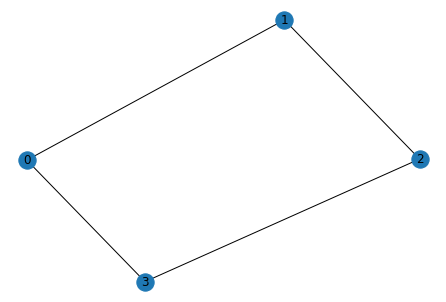

In [2]:
N = 4
graph=[(0, 1,1.0), (0, 3,3.0), (1, 2,2.0), (2, 3,1.0)] 
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [3]:
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]

In [4]:
def initialization(circuit):
    for qubit in circuit.qubits:
        circuit.h(qubit)
    return circuit

In [5]:
def cost_unitary_layer(circuit, gamma):
    for edge in graph:
        op = RZZGate(gamma*edge[2])
        circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
    return circuit

In [6]:
def mixture_unitary_layer(circuit,alpha):
    for qubit in circuit.qubits:
        circuit.rx(alpha,qubit)
    circuit.barrier()
    return circuit

In [7]:
n_layers = 4
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
def anasatz(params):
    gammas = [params[0], params[2], params[4], params[6]]
    alphas = [params[1], params[3], params[5], params[7]]
    q = QuantumRegister(N)
    c = ClassicalRegister(N)
    circuit = QuantumCircuit(q,c)
    circuit = initialization(circuit)
    for i in range(n_layers):
        circuit = cost_unitary_layer(circuit, gammas[i])
        circuit = mixture_unitary_layer(circuit,alphas[i])
    circuit.measure(circuit.qubits,c)
    
    simulator = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, simulator).result()
    counts = result.get_counts(circuit)
    results = counts.keys()
    new_res=[]
    for key in results:
        hold=[]
        for i in range(0,len(key)):
            hold.append(int(key[i]))
        for i in range(0,counts[key]):
            new_res.append(hold)
    return circuit,counts,new_res

In [8]:
def cost_function(params):
    circuit,counts,result = anasatz(params)
    total_cost = 0
    for i in range(len(result)):
        for edge in graph:
            total_cost += (A[edge[0]][edge[1]])*(1-2*result[i][edge[0]])*(1-2*result[i][edge[1]]) + (A[edge[1]][edge[0]])*(1-2*result[i][edge[1]])*(1-2*result[i][edge[0]])
    total_cost = total_cost/1024
    return total_cost 
cost = cost_function(params)
print(cost)

-8.8984375


In [9]:
num_iters = 100
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')

Out:      fun: -12.79296875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 76
  status: 1
 success: True
       x: array([-0.34971425,  4.23847763, -1.38747104,  0.39760102,  0.21985178,
       -0.90034636,  0.43785646, -2.28212515])


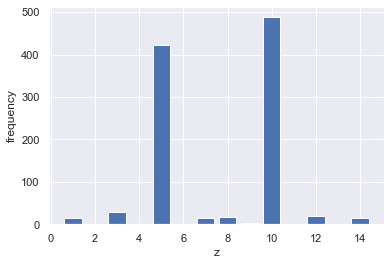

In [10]:
circuit,counts,result = anasatz(out['x'])
x=[]
y=[]
for key in counts.keys():
    number=0
    for i in range(0,len(key)):
        number = number + (2**i)*int(key[i])
    x.append(number)
    y.append(counts[key])
import seaborn as sns
sns.set()
plt.bar(x,y,color='b')
plt.xlabel("z")
plt.ylabel("frequency")
plt.show()

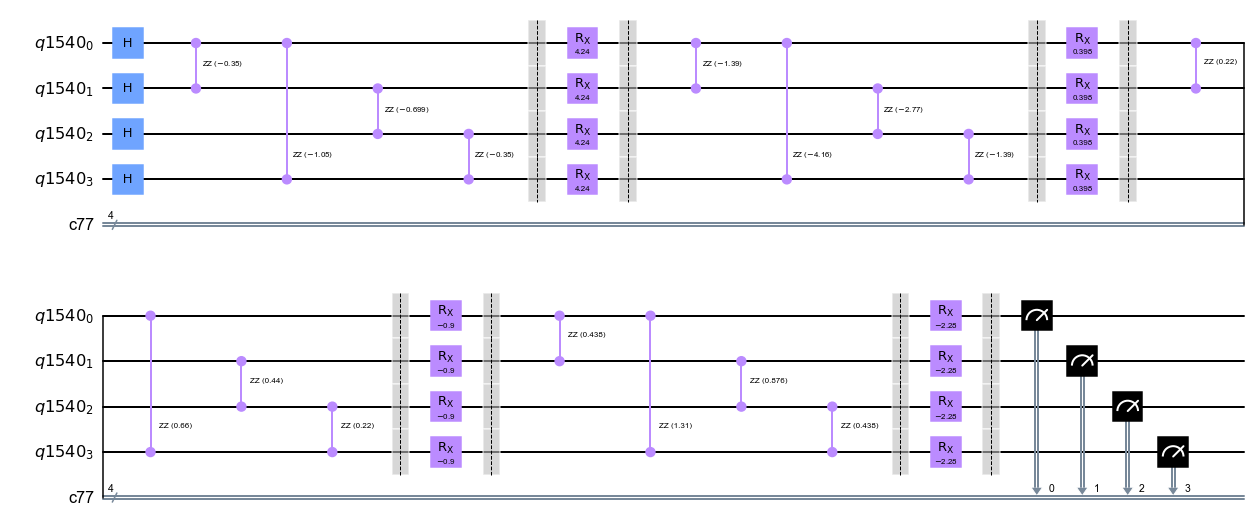

In [11]:
circuit.draw('mpl')

In [15]:
best_cost_brute = 0
for b in range(2**N):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(N)))]
    cost = 0
    for i in range(N):
        for j in range(N):
            cost = cost + A[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(N)]

print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 4.0
case = [0, 1, 0, 0] cost = 3.0
case = [1, 1, 0, 0] cost = 5.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 7.0
case = [0, 1, 1, 0] cost = 2.0
case = [1, 1, 1, 0] cost = 4.0
case = [0, 0, 0, 1] cost = 4.0
case = [1, 0, 0, 1] cost = 2.0
case = [0, 1, 0, 1] cost = 7.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 5.0
case = [1, 0, 1, 1] cost = 3.0
case = [0, 1, 1, 1] cost = 4.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 7.0
